In [ ]:
!pip install torch torchvision matplotlib


In [ ]:
import os
import urllib.request
import tarfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

os.makedirs("oxford_pets", exist_ok=True)
os.chdir("oxford_pets")

urls = {
    "images": "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
    "annotations": "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
}

for name, url in urls.items():
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
        with tarfile.open(filename, "r:gz") as tar:
            tar.extractall()

os.chdir("..")

for root, _, files in os.walk("oxford_pets/images"):
    for file in files:
        if file.endswith(".mat"):
            os.remove(os.path.join(root, file))

In [6]:
class OxfordPetsDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images = sorted([f for f in os.listdir(images_dir) if f.endswith(".jpg")])
        self.transform = transform
        self.mask_transform = T.Resize((128, 128))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx].replace(".jpg", ".png"))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = np.array(mask)
        mask = (mask == 2).astype(np.float32)
        mask = torch.tensor(mask).unsqueeze(0)

        return image, mask

transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

train_dataset = OxfordPetsDataset("oxford_pets/images", "oxford_pets/annotations/trimaps", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


In [2]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU()
            )

        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = CBR(256, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return torch.sigmoid(self.final(d1))

In [7]:
model = UNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(train_loader)} processed", flush=True)

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Batch 0/1848 processed
Batch 10/1848 processed
Batch 20/1848 processed
Batch 30/1848 processed
Batch 40/1848 processed
Batch 50/1848 processed
Batch 60/1848 processed
Batch 70/1848 processed
Batch 80/1848 processed
Batch 90/1848 processed
Batch 100/1848 processed
Batch 110/1848 processed
Batch 120/1848 processed
Batch 130/1848 processed
Batch 140/1848 processed
Batch 150/1848 processed
Batch 160/1848 processed
Batch 170/1848 processed
Batch 180/1848 processed
Batch 190/1848 processed
Batch 200/1848 processed
Batch 210/1848 processed
Batch 220/1848 processed
Batch 230/1848 processed
Batch 240/1848 processed
Batch 250/1848 processed
Batch 260/1848 processed
Batch 270/1848 processed
Batch 280/1848 processed
Batch 290/1848 processed
Batch 300/1848 processed
Batch 310/1848 processed
Batch 320/1848 processed
Batch 330/1848 processed
Batch 340/1848 processed
Batch 350/1848 processed
Batch 360/1848 processed
Batch 370/1848 processed
Batch 380/1848 processed
Batch 390/1848 processed
Batch 400/1

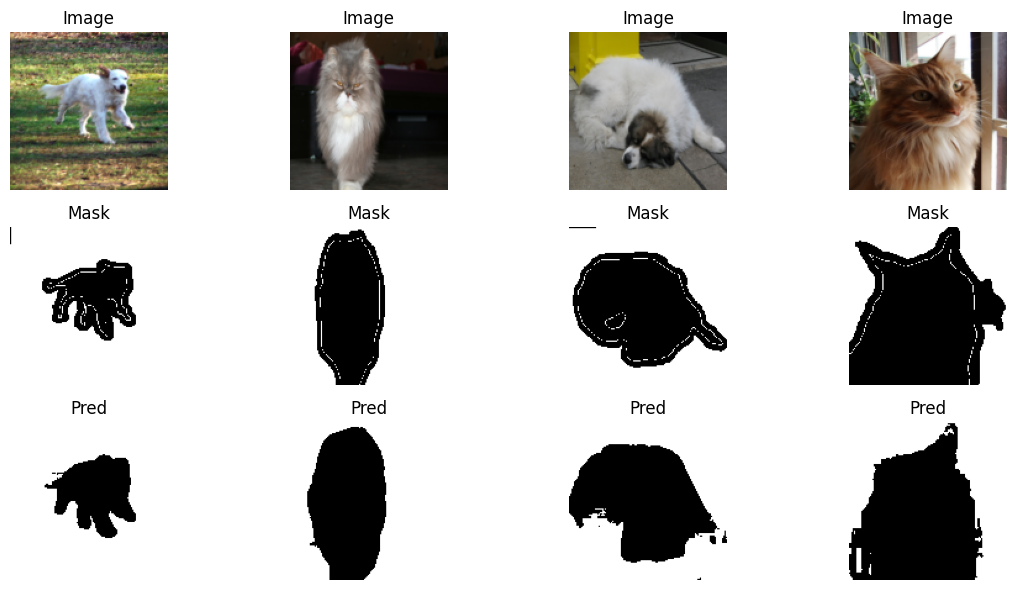

In [10]:
model.eval()
with torch.no_grad():
    images, masks = next(iter(train_loader))
    images = images.to(device)
    masks = masks.to(device)
    preds = model(images)

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0).cpu())
    plt.title("Image")
    plt.axis('off')

    plt.subplot(3, 4, i+5)
    plt.imshow(masks[i][0].cpu(), cmap='gray')
    plt.title("Mask")
    plt.axis('off')

    plt.subplot(3, 4, i+9)
    plt.imshow(preds[i][0].cpu().numpy() > 0.5, cmap='gray')
    plt.title("Pred")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import jaccard_score
import numpy as np

model.eval()
iou_scores = []

with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        preds = model(images)
        preds = (preds > 0.5).float()

        for i in range(images.size(0)):
            pred_flat = preds[i][0].cpu().numpy().flatten()
            mask_flat = masks[i][0].cpu().numpy().flatten()
            iou = jaccard_score(mask_flat, pred_flat, average='binary')
            iou_scores.append(iou)

print(f"Mean IoU over dataset: {np.mean(iou_scores):.4f}")

Mean IoU over dataset: 0.8158
